In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests_cache
import yfinance as yf
import torch
import torch.nn as nn

%matplotlib inline
sns.set_theme()
device = torch.device("mps")


session = requests_cache.CachedSession("base-model-2.cache")
print(device)

mps


In [96]:
sp500_df = yf.download(
    pd.read_csv("../data/sp500-firms.csv")["Symbol"].values.tolist(),
    period="10y",
    interval="1d",
    # session=session
)
sp500_df = sp500_df["Close"]

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')


In [58]:
sp500 = sp500_df.fillna(0).values

In [59]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
sp500 = scaler.fit_transform(sp500)

In [60]:
pd.DataFrame(sp500).head()

,0
0,0.011256
1,0.010288
2,0.013306
3,0.013042
4,0.013622


Axis 0 is temporal.

Axis 1 is individual companies.

In [61]:
def split_data(raw_data: np.ndarray, train_size: float = 0.8, lookback_period: int = 30, lookforward_period: int = 30):
    """
    Takes a 2-array of data with axis 0 being temporal and axis 1 being companies and splits it into train and test sets.
    
    The first train_size percent of each timeseries is used for training and the rest is used for testing. Cross-validation folds
    are created using the lookback_period parameter in a sliding window paradigm. The target of each fold is the next value in the
    timeseries."""

    train_size = int(raw_data.shape[0] * train_size)
    train_data = raw_data[:train_size, :]
    test_data = raw_data[train_size:, :]

    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(lookback_period, train_data.shape[0] - lookforward_period + 1):
        X_train.append(train_data[i-lookback_period:i, :])
        y_train.append(train_data[i:i+lookforward_period, :])

    for i in range(lookback_period, test_data.shape[0] - lookforward_period + 1):
        X_test.append(test_data[i-lookback_period:i, :])
        y_test.append(test_data[i:i+lookforward_period, :])

    return (
        np.array(X_train),
        np.array(y_train),
        np.array(X_test),
        np.array(y_test),
    )

train_size = 0.8
lookback_period = 30
lookforward_period = 30
X_train, y_train, X_test, y_test = split_data(sp500, train_size=train_size, lookback_period=lookback_period, lookforward_period=lookforward_period)

In [62]:
X_train = X_train.transpose(2, 0, 1).reshape(-1, lookback_period)
y_train = y_train.transpose(2, 0, 1).reshape(-1, lookforward_period)
X_test = X_test.transpose(2, 0, 1).reshape(-1, lookback_period)
y_test = y_test.transpose(2, 0, 1).reshape(-1, lookforward_period)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1953, 30)
y_train shape: (1953, 30)
X_test shape: (445, 30)
y_test shape: (445, 30)


X_train, X_test shape: (Number of windows, window size, number of companies)

y_train, y_test shape: (Next value for each window, number of companies)

In [63]:
# remove a sample if its row (axis 1) contains a 0.0
train_mask = np.all(X_train != 0.0, axis=(1))
test_mask = np.all(X_test != 0.0, axis=(1))

X_train = X_train[train_mask, :].reshape(-1, lookback_period, 1)
y_train = y_train[train_mask, :]
X_test = X_test[test_mask, :].reshape(-1, lookback_period, 1)
y_test = y_test[test_mask, :]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1923, 30, 1)
y_train shape: (1923, 30)
X_test shape: (445, 30, 1)
y_test shape: (445, 30)


Now:

X_train, X_test shape: (Number of windows, window size)

y_train, y_test shape: (Next value for each window)

In [64]:
SUBSAMPLE_DATA = False
SUBSAMPLE_PERCENT = 0.1

if SUBSAMPLE_DATA:
    # Select a random subsample of the data
    subsample_train = np.random.choice(X_train.shape[0], int(X_train.shape[0] * SUBSAMPLE_PERCENT))
    subsample_test = np.random.choice(X_test.shape[0], int(X_test.shape[0] * SUBSAMPLE_PERCENT))

    X_train = X_train[subsample_train, :, :]
    y_train = y_train[subsample_train, :]
    X_test = X_test[subsample_test, :, :]
    y_test = y_test[subsample_test, :]

# convert train/test arrays to torch.Tensor
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

print(f"Type of X_train: {type(X_train)}")
print(f"Type of y_train: {type(y_train)}")
print(f"Type of X_test: {type(X_test)}")
print(f"Type of y_test: {type(y_test)}")

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Type of X_train: <class 'torch.Tensor'>
Type of y_train: <class 'torch.Tensor'>
Type of X_test: <class 'torch.Tensor'>
Type of y_test: <class 'torch.Tensor'>
Shape of X_train: torch.Size([1923, 30, 1])
Shape of y_train: torch.Size([1923, 30])
Shape of X_test: torch.Size([445, 30, 1])
Shape of y_test: torch.Size([445, 30])


In [65]:
input_size = 1 # num channels in input
num_layers = 4 # num of hidden layers
hidden_size = 64 # num of hidden nodes in each layer
output_size = lookforward_period # timesteps to predict

In [2]:
class LSTMModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x: torch.Tensor):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

NameError: name 'nn' is not defined

In [1]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=1)

print(model)

NameError: name 'LSTMModel' is not defined

In [68]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# now that input windows are no longer grouped by company, we can shuffle the data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [69]:
from tqdm.notebook import tqdm, trange

num_epochs = 100
train_hist = []
test_hist = []

progress_bar = trange(num_epochs, desc="Epochs", postfix={"train_loss": 0.0, "test_loss": 0.0})
train_bar = tqdm(total=len(train_loader), desc="Training", leave=True)
test_bar = tqdm(total=len(test_loader), desc="Testing", leave=True)

for epoch in progress_bar:
    epoch_loss = 0.0

    # reset the progress bars
    train_bar.reset()
    test_bar.reset()

    # training loop
    model.train()
    for batch_X, batch_y in train_loader:
        # tick the progress bar
        train_bar.update()

        # forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    train_bar.refresh()
    train_hist.append(epoch_loss / len(train_loader))

    # testing loop
    model.eval()
    with torch.no_grad():
        epoch_loss = 0.0

        for batch_X, batch_y in test_loader:
            # tick the progress bar
            test_bar.update()

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            loss = loss_fn(y_pred, batch_y)

            epoch_loss += loss.item()
        
        test_bar.refresh()
        test_hist.append(epoch_loss / len(test_loader))

    
    # print stats
    # print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_hist[-1]} | Test Loss: {test_hist[-1]}")

    # update progress bar
    progress_bar.postfix = {"train_loss": float(f"{train_hist[-1]:.6f}"), "test_loss": float(f"{test_hist[-1]:.6f}")}

# close progress bars
train_bar.close()
test_bar.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s, test_loss=0, train_loss=0]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

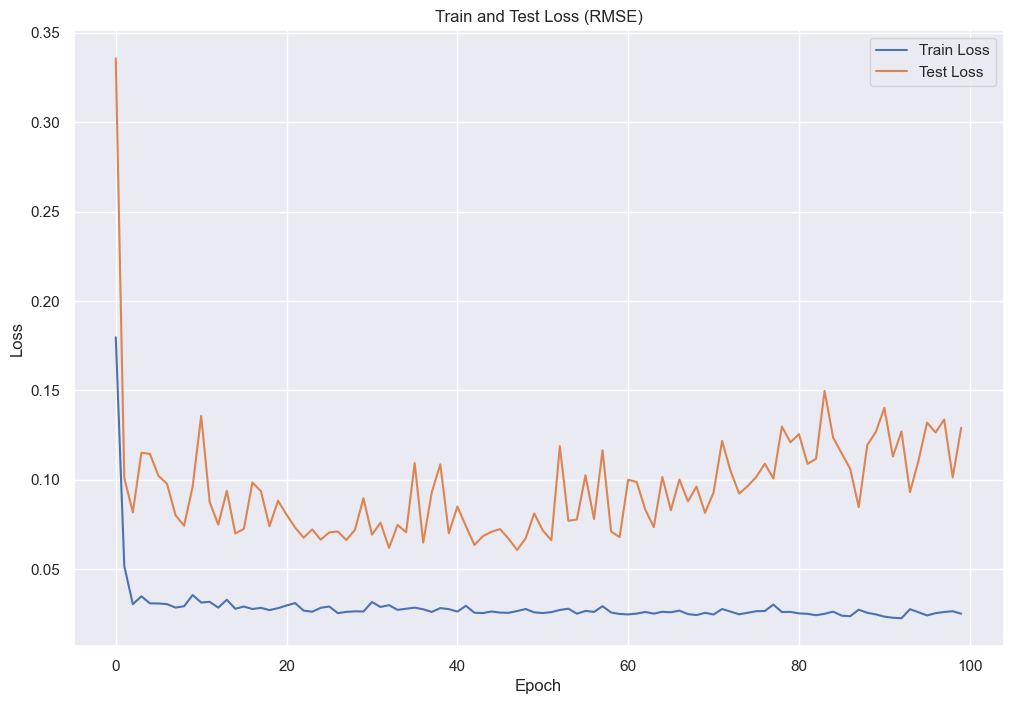

In [70]:
# plot train and test loss
train_hist = np.array(train_hist)
test_hist = np.array(test_hist)

train_rmse = np.sqrt(train_hist)
test_rmse = np.sqrt(test_hist)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_rmse, label="Train Loss")
ax.plot(test_rmse, label="Test Loss")
ax.set_title("Train and Test Loss (RMSE)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

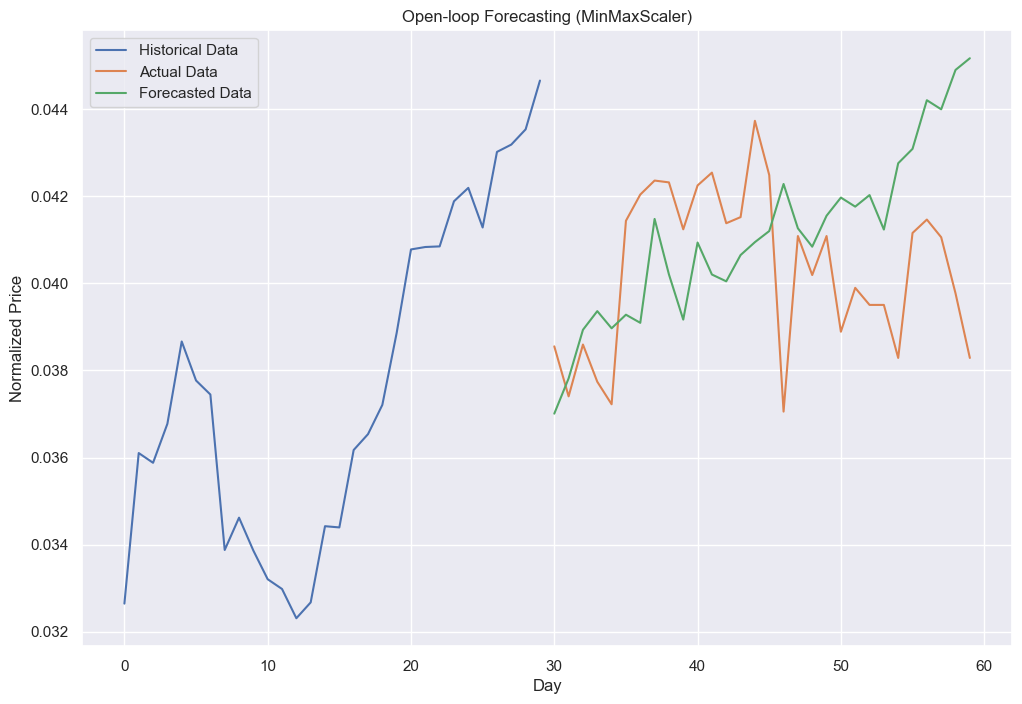

In [95]:
# Open-loop forecasting

num_forecast_steps = 30
sequence = np.random.randint(0, 1) # which sequence to use for forecasting

test_sequence = sp500[160:320, sequence] # test data
historical_data = test_sequence[:lookback_period]
forecasted_data = []

model.eval()
with torch.no_grad():
    historical_data_tensor = torch.from_numpy(historical_data).view(1, -1, 1).float().to(device)
    forecasted_data = model(historical_data_tensor).cpu().numpy()[0]


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_sequence[:lookback_period], label="Historical Data")
ax.plot(np.arange(lookback_period, lookback_period + lookforward_period), test_sequence[lookback_period:lookback_period + lookforward_period], label="Actual Data")
ax.plot(np.arange(lookback_period, lookback_period + len(forecasted_data)), np.array(forecasted_data), label="Forecasted Data")
ax.set_title("Open-loop Forecasting (MinMaxScaler)")
ax.set_xlabel("Day")
ax.set_ylabel("Normalized Price")
ax.legend()